In [2]:
!pip install deepvision-toolkit

In [3]:
import deepvision
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
sam = deepvision.models.SAM_B(backend='pytorch', weights='SA-1B')
sam.cuda();

In [5]:
print(f'Number of parameters: {sum(p.numel() for p in sam.parameters() if p.requires_grad)}')

Number of parameters: 93735472


# Using the SAM (Segment Anything) Model

With SAM loaded - you can use it on three levels:

- **Vanilla SAM (Low-level):** You can pass a batch of images, keypoints, boxes and labels to the model. This is the low-level base model you can use to interact with the output logits and unprocessed output masks.
- **Promptable SAM (Mid-level):** A wrapper around the base model allows you to set an image, re-use the embeddings for that image (i.e. run the backbone only once and hash the results), and run different prompts on the model (keypoints, boxes, both or none). With it, you can also easily visualize masks and confidence scores.
- **Automatic SAM (High-level):** A wrapper around the PromptableSAM that automatically generates all masks that can easily be plotted onto a resulting image.

# Load Example image

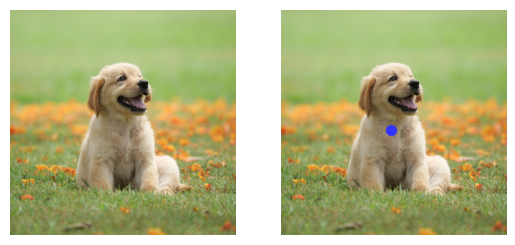

In [6]:
import cv2
image = cv2.imread('test_image_2.jpg')
image = cv2.resize(image, (1024, 1024))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_with_point = cv2.circle(image.copy(), (500,550), radius=25, color=(50, 50, 255), thickness=-1)

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image)
ax[1].imshow(image_with_point)

for axis in ax:
    axis.axis('off')

# Base Vanilla Model

In [7]:
keypoint = torch.tensor([[[500., 550.]]])
torch_image = torch.from_numpy(image).permute(2, 0, 1).cuda()
label = torch.tensor([[1]])

inputs = [{
    "image": torch_image,
    "original_size": (1024, 1024),
    "points_coords": keypoint,
    "point_labels": label,
    "boxes": None,
    "mask_inputs": None,
}]

outputs = sam(inputs, multimask_output=True)

In [8]:
masks = outputs[0]['masks'].squeeze(0).permute(1, 2, 0).detach().cpu().numpy().astype('float')
masks = np.transpose(masks, (2, 0, 1))

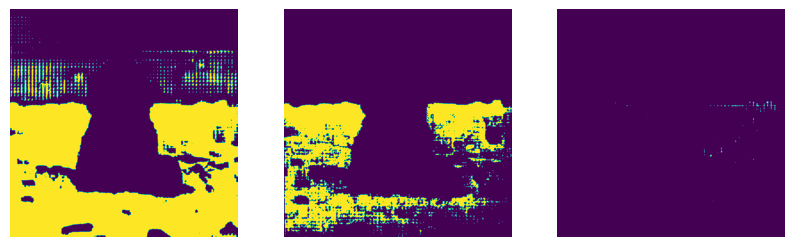

In [9]:
import numpy as np

fig, ax = plt.subplots(1, masks.shape[0], figsize=(10, 4))

for i, mask in enumerate(masks):
    ax[i].imshow(mask)
    ax[i].axis('off')

# Interactive Promptable Model

The interactive model allows you to set one image, and calculate embeddings for it, and re-use those embeddings for all subsequent calls. Furthermore, the outputs can be neatly parsed and visualized with the help of a single function, making `PromptableSAM` a useful class for building applications powered by SAM.

In [10]:
promptable_sam = deepvision.models.PromptableSAM(sam)

In [11]:
promptable_sam.set_image(image)

In [12]:
# No prompt
results = promptable_sam.predict(multimask_output=True)

In [13]:
# Add keypoints
keypoint = np.array([[500., 550.]])
labels = np.array([1])

masks, scores, logits = promptable_sam.predict(point_coords=keypoint,
                                               point_labels=labels)

In [14]:
masks, scores, logits = promptable_sam.predict(point_coords=keypoint, point_labels=labels)

In [15]:
%timeit promptable_sam.predict(point_coords=keypoint, point_labels=labels)

8.07 ms ± 410 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


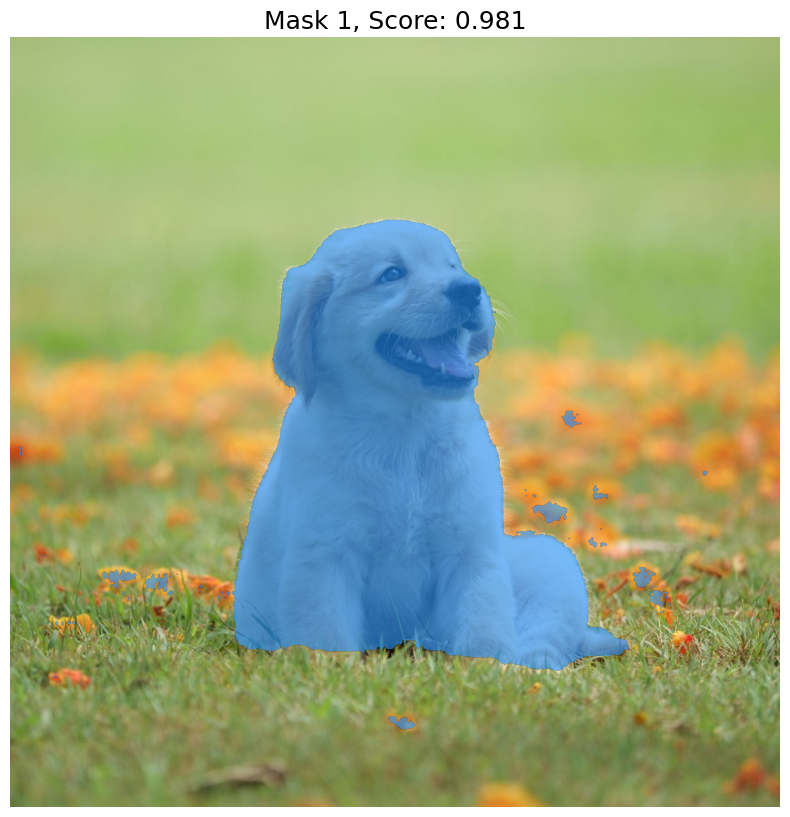

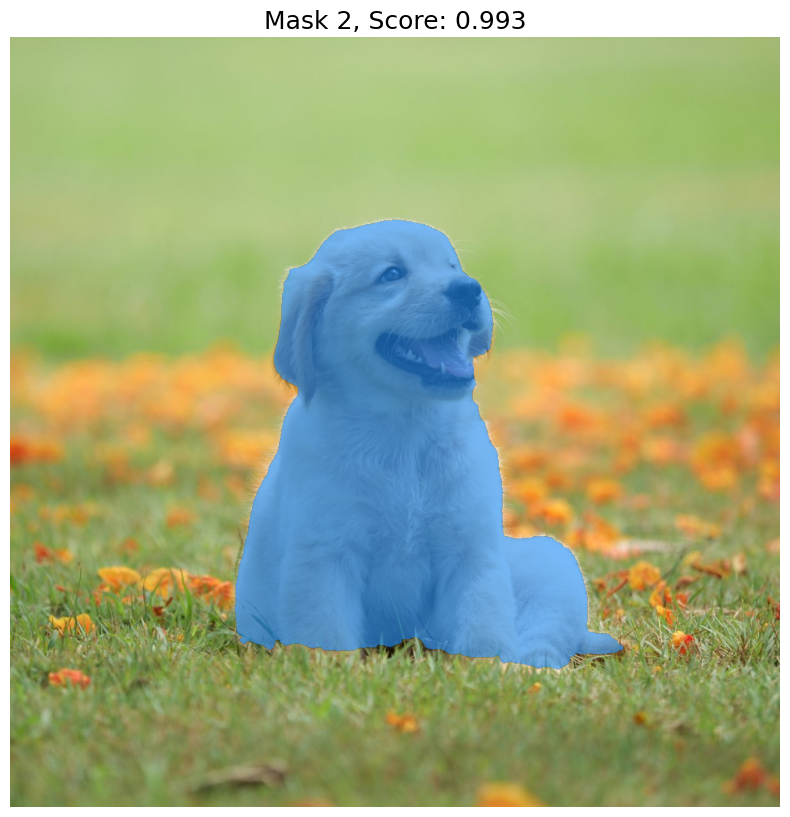

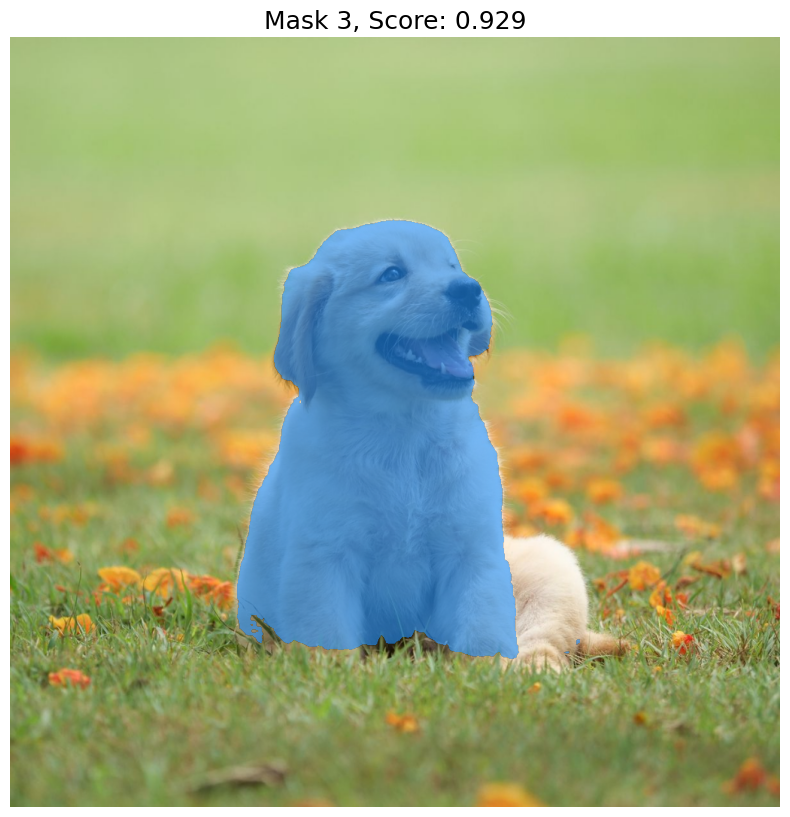

In [16]:
from deepvision.utils import process_mask, process_mask_generator

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    mask = process_mask(mask)
    plt.imshow(mask)
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [17]:
# Add boxes
keypoint = np.array([[450., 350.]])
label = np.array([1])
box = np.array([350, 250, 650, 500]) #xyxy format, first xy is top left

masks, scores, logits = promptable_sam.predict(point_coords=keypoint,
                                               point_labels=label,
                                               box=box,
                                               multimask_output=False)

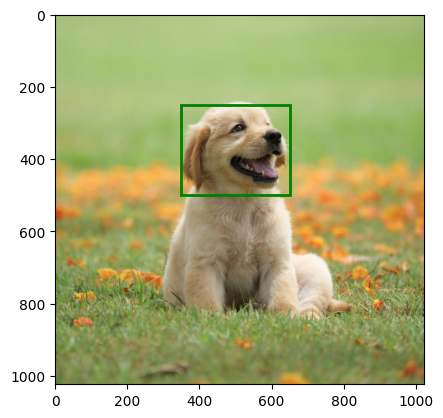

In [18]:
# Plot the area of interest
x0, y0 = box[0], box[1]
w, h = box[2] - box[0], box[3] - box[1]

fig, ax = plt.subplots()
rect = plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)
ax.imshow(image)
ax.add_patch(rect)

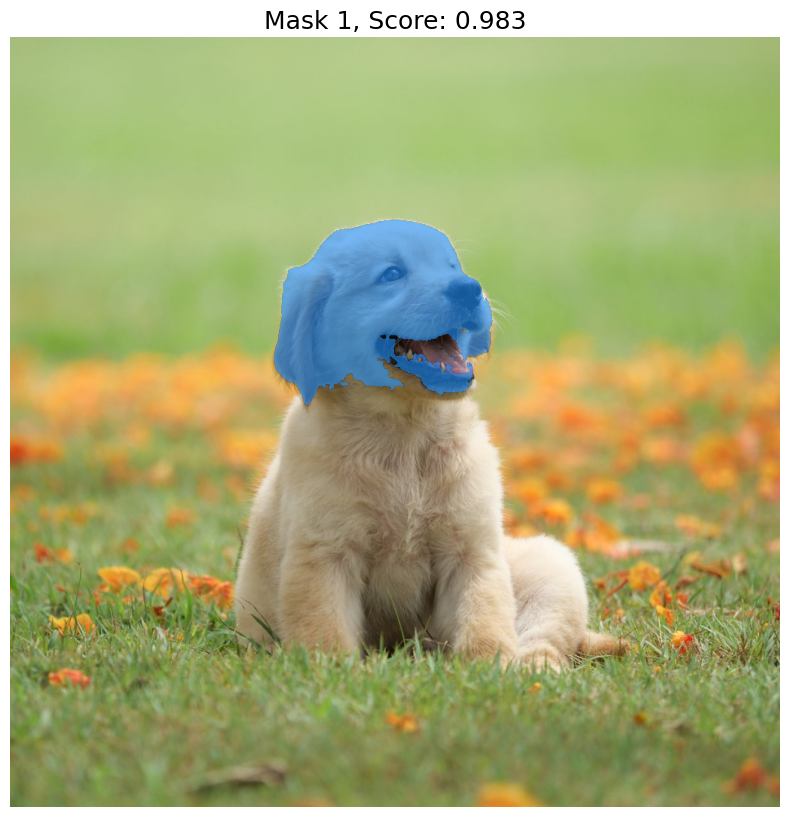

In [19]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    mask = process_mask(mask)
    plt.imshow(mask)
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

# Automatic Mask Generator

`SAMAutoMaskGenerator` is a high-level API that lets you run inference with as little as a single line, and generates masks for everything it can "find" in an image.
You pass the specific SAM instance you want to use to it, followed by the image, and can visualize the results with `process_mask_generator` which returns an NDarray of colored masks:

In [20]:
mask_generator = deepvision.models.SAMAutoMaskGenerator(sam) # Automatic Mask Generator
sam_result = mask_generator.generate(image)

In [21]:
processed_results = process_mask_generator(sam_result, opacity=0.5)

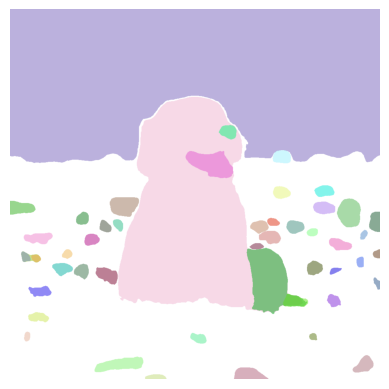

In [22]:
fig, ax = plt.subplots()
for mask in processed_results:
    ax.imshow(mask)
    ax.axis('off')

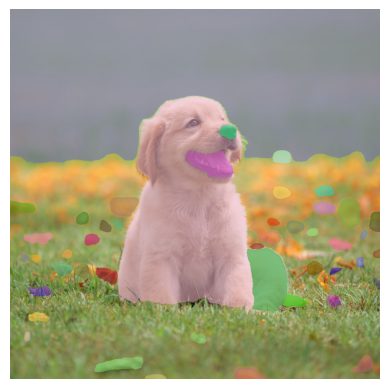

In [23]:
fig, ax = plt.subplots()
ax.imshow(image)
for mask in processed_results:
    ax.imshow(mask)
    ax.axis('off')

## End-to-end Automatic Mask Generation

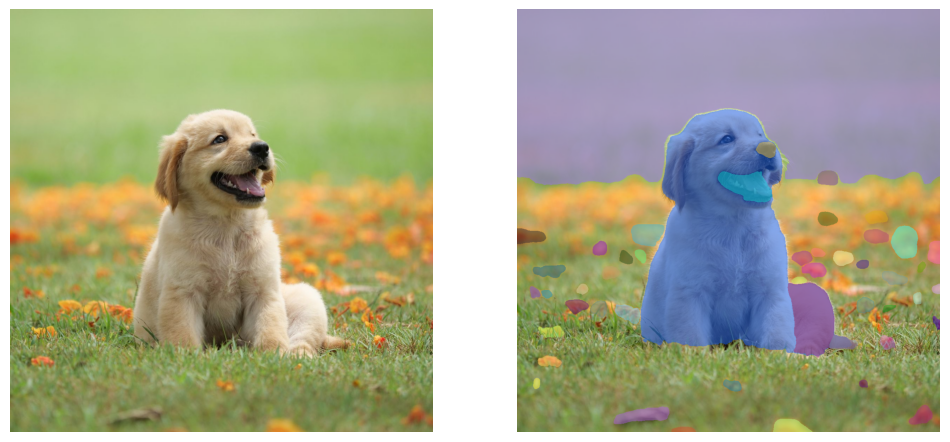

In [24]:
import deepvision
import matplotlib.pyplot as plt

# Load Segment Anything (SAM) with a ViTDetB backbone and weights
sam = deepvision.models.SAM_B(backend='pytorch', weights='SA-1B')
sam.cuda();

# Wrap low-level SAM into a high-level automatic mask generator
mask_generator = deepvision.models.SAMAutoMaskGenerator(sam)
sam_result = mask_generator.generate(image)

# Process outputs into a set of plottable images
processed_results = process_mask_generator(sam_result, opacity=0.5)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(image)

for mask in processed_results:
    ax[1].imshow(mask)
    ax[1].axis('off')